In [3]:
from ipywidgets import interact
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import shutil
import copy
from tqdm import tqdm
import pandas as pd
import torch
from tempfile import TemporaryDirectory



# Étape 1 : Generation du fichier csv

In [4]:
# Dossier contenant les images classées par couleur de peau
base_dir = "/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/CelebA_Predict_Hawa"

# Liste pour stocker les informations à sauvegarder dans le CSV
data = []

# Parcours des sous-dossiers (couleurs de peau)
for skin_color_folder in tqdm(os.listdir(base_dir), desc="Creation du fichier csv", unit="image"):
    skin_color_path = os.path.join(base_dir, skin_color_folder)
    if os.path.isdir(skin_color_path):
        # Parcours des sous-sous-dossiers (genres)
        for gender_folder in os.listdir(skin_color_path):
            gender_path = os.path.join(skin_color_path, gender_folder)
            if os.path.isdir(gender_path):
                # Liste des fichiers (images) dans le sous-sous-dossier
                image_files = [f for f in os.listdir(gender_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
                # Parcours des images dans le sous-sous-dossier
                for image_file in image_files:
                    # Ajouter les informations à la liste de données
                    data.append({'image': image_file, 'skin_color': skin_color_folder, 'genre': gender_folder})
            
# Convertir la liste de données en DataFrame pandas
df = pd.DataFrame(data)

# Enregistrer le DataFrame dans un fichier CSV
df.to_csv("CelebA_hand_classifier.csv", index=False)

print("Les informations ont été sauvegardées dans le fichier CSV.")


Creation du fichier csv: 100%|████████████████| 6/6 [00:00<00:00, 311.44image/s]

Les informations ont été sauvegardées dans le fichier CSV.


## Etape 2: Tests statistiques

In [5]:
import pandas as pd
import seaborn as sns
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import os
from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu, kruskal


In [6]:
data = pd.read_csv('CelebA_hand_classifier.csv')

In [7]:
# Afficher les premières lignes pour comprendre la structure
data.head()

,image,skin_color,genre
0,001105.jpg,Darkest,male
1,076428.jpg,Darkest,male
2,003262.jpg,Darkest,male
3,149408.jpg,Darkest,male
4,044462.jpg,Darkest,male


In [8]:
# Vérifier le nombre de valeurs uniques dans chaque colonne
data.nunique()

image         1562
skin_color       5
genre            2
dtype: int64

In [9]:
df = data.copy()

In [10]:
def effectif_variables(colonne):
    return df[colonne].value_counts().sort_index()

In [11]:
df1 = df.drop(["image"],axis=1)
interact(effectif_variables, colonne=df1);

interactive(children=(Dropdown(description='colonne', options=('skin_color', 'genre'), value='skin_color'), Ou…

In [12]:
def proportion(colonne):
    total = len(df)
    proportion = effectif_variables(colonne) / total
    return proportion

In [13]:
df1 = df.drop(["image"],axis=1)
interact(proportion, colonne=df1);

interactive(children=(Dropdown(description='colonne', options=('skin_color', 'genre'), value='skin_color'), Ou…

In [14]:
def bar_plot(colonne):
    plt.figure(figsize=(12,4))
    
    df[colonne].value_counts().plot(kind='bar') # normalize=True
    plt.ylabel('Proportion')
    plt.xlabel(f'Distribution of {colonne}')
    plt.show()

In [15]:
df1 = df.drop(["image"],axis=1)
interact(bar_plot, colonne=df1);

interactive(children=(Dropdown(description='colonne', options=('skin_color', 'genre'), value='skin_color'), Ou…

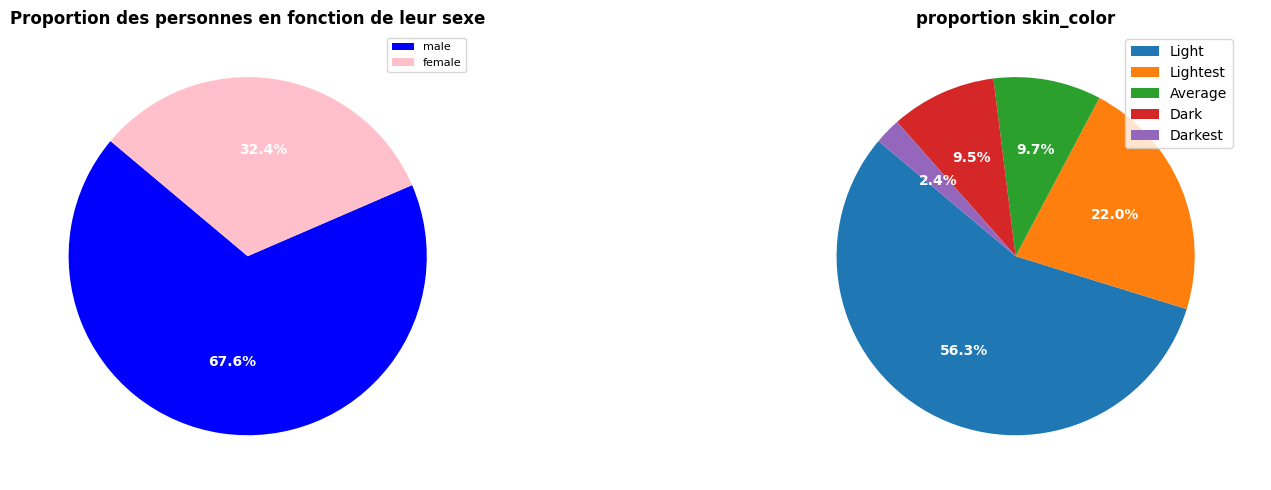

In [16]:
# Etude de proportion par rapport au sexe
sexe_counts = df['genre'].value_counts()
ethinic_counts = df['skin_color'].value_counts()

fig,(ax0, ax1) = plt.subplots(nrows = 1, ncols = 2,figsize=(18, 5))
ax0.pie(sexe_counts, labels=sexe_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'pink'],
       textprops={'color': 'white', 'weight': 'bold'})
ax0.set_title('Proportion des personnes en fonction de leur sexe', fontweight='bold')
ax0.legend(prop={'size':8})

# Etude de proportion par rapport aux skin_colors
ax1.pie(ethinic_counts, labels= ethinic_counts.index, autopct='%1.1f%%', startangle=140,
       textprops={'color': 'white', 'weight': 'bold'})
ax1.set_title('proportion skin_color', fontweight='bold')
ax1.legend(prop={'size':10})


fig.tight_layout()
plt.show()

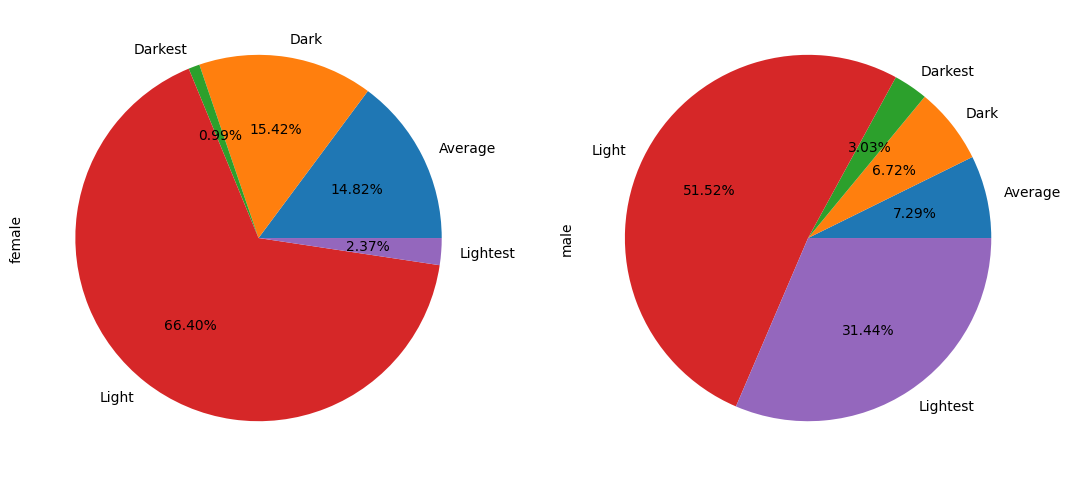

In [17]:
gender_counts = df.groupby('skin_color')['genre'].value_counts().unstack()
gender_counts.plot(kind='pie', subplots=True, figsize=(13, 8), autopct='%2.2f%%',legend=False)
plt.show()

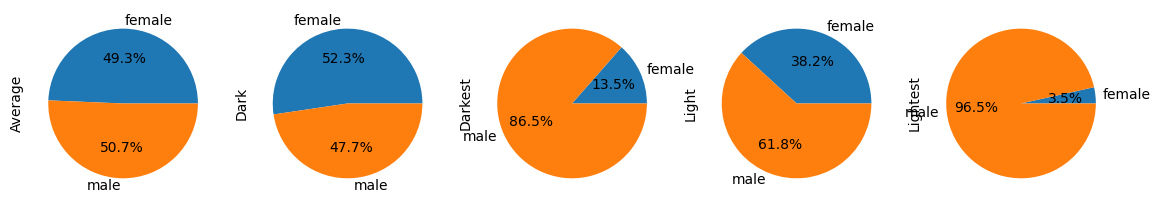

In [18]:
gender_counts = df.groupby('genre')['skin_color'].value_counts().unstack()
gender_counts.plot(kind='pie', subplots=True, figsize=(14, 9), autopct='%1.1f%%',legend=False)

plt.show()

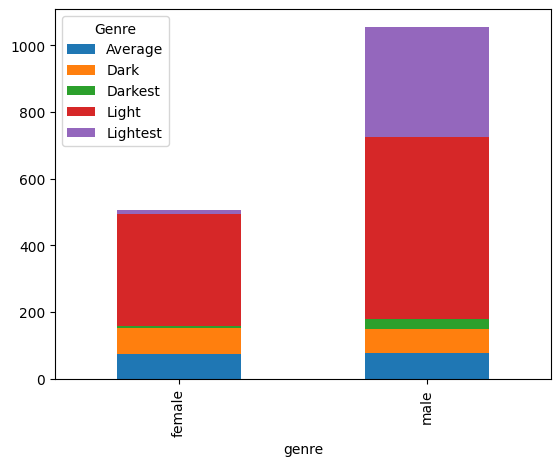

In [19]:
cross_tab = pd.crosstab(df['genre'], df['skin_color'])
stacked_bar = cross_tab.plot(kind='bar', stacked=True)
plt.legend(title='Genre')
plt.show()


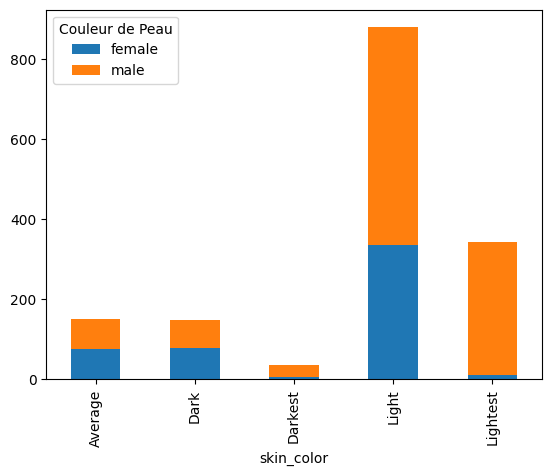

In [20]:
cross_tab = pd.crosstab(df['skin_color'], df['genre'])
stacked_bar = cross_tab.plot(kind='bar', stacked=True)
plt.legend(title='Couleur de Peau')
plt.show()


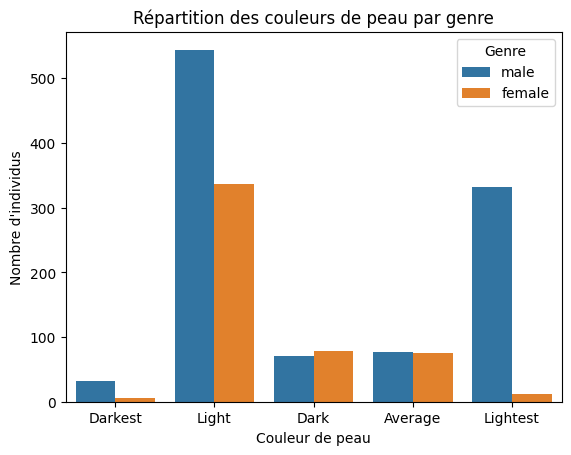

In [21]:
# Répartition des couleurs de peau par genre

sns.countplot(x='skin_color', hue='genre', data=df)
plt.xlabel('Couleur de peau')
plt.ylabel('Nombre d\'individus')
plt.title('Répartition des couleurs de peau par genre')
plt.legend(title='Genre')
plt.show()


# Analyse de la distribution du genre par couleur de peau

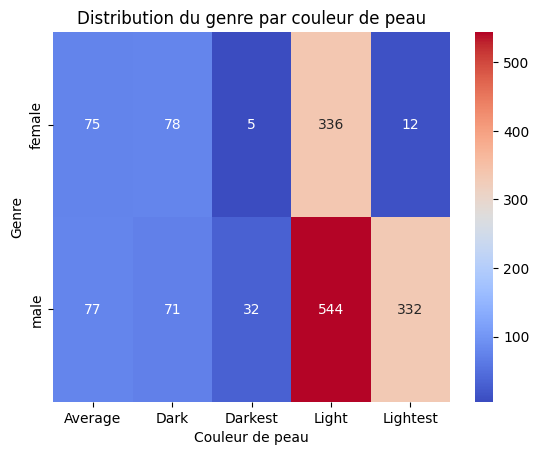

In [22]:
# Créer un tableau croisé du genre par couleur de peau
cross_tab = pd.crosstab(df['genre'], df['skin_color'])

# Visualiser la distribution du genre par couleur de peau
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d')
plt.title('Distribution du genre par couleur de peau')
plt.xlabel('Couleur de peau')
plt.ylabel('Genre')
plt.show()

# Étape 3 : Test d'independance

In [23]:
def chi2_test(column1, column2):
    contingency_table = pd.crosstab(data[column1], data[column2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Test du Chi-deux pour {column1} et {column2}:")
    print(f"Chi2 : {chi2}, p-value : {p}")

chi2_test('genre', 'skin_color')

Test du Chi-deux pour genre et skin_color:
Chi2 : 197.75190123136065, p-value : 1.1433552245590169e-41


# Calcul du coefficient V de Cramer

Evaluer la force de l’association entre les variables catégorielles

In [25]:
import numpy as np

def cramers_v(chi2, n, r, c):
    """Calcul du coefficient de V de Cramer."""
    return np.sqrt(chi2 / (n * min(r-1, c-1)))

def calculate_cramers_v(chi2, contingency_table):
    """Calcul du coefficient de V de Cramer à partir du Chi2 et du tableau de contingence."""
    n = contingency_table.values.sum()  # Taille de l'échantillon
    r, c = contingency_table.shape  # Nombre de niveaux pour chaque variable
    
    # Calcul du coefficient de V de Cramer
    v_cramer = cramers_v(chi2, n, r, c)
    return v_cramer


chi2_value = 197.75190123136065
contingency_table = pd.crosstab(df['genre'], df['genre']) 
v_cramer = calculate_cramers_v(chi2_value, contingency_table)

print(f"Coef. de V de Cramer : {v_cramer}")


Coef. de V de Cramer : 0.3558113676394559
